Explanation of notebooks: 

- The $\textbf{Exoplanet Practice notebook}$ models the transits for the planetary system, and subtracts the model from the pld data to see if histogram of noise is gaussian. This notebook finds there is lots of non-gaussian noise, indiciating a bug. 
- The $\textbf{Outliers Removal - Histogram-bug notebook}$ tries using MAST lightkurve instead of pld but still replicates this bug.
- The $\textbf{TPF files notebook}$ explains why the pld data had weird features. If I stitch lightcurves from different quarters and then flatten them, they introduce those features. If I flatten each quarter and THEN stitch, the features are no longer there. 
- The $\textbf{Outliers Removal - Histogram-pld notebook}$ goes back to using pld but fixes the bug (found to be using the wrong time array in exoplanet model). This notebook also tries to explore the pld data's weird featurues  
- The $\textbf{Outliers Removal - Histogram-sap notebook}$ tries using sap but fixes the time array bug 
- The $\textbf{Outliers Removal - Histogram notebook}$ uses MAST lightkurve and fixes the bug (found to be using the wrong time array in exoplanet model). Histogram looks good but folded light curve found to have shoulders. 

The MAST lightkurve + time array bug fix was the combination that led to the least amount of outliers. However, the folded light curve had shoulders, so flattening needs to be removed. 


In [1]:
import exoplanet as xo 
import lightkurve as lk 
import astropy.units as units
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline
from astropy.time import Time 
import sys 
sys.path.append("helpers")
import data 
import xo_archive
xo.utils.docs_setup()
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.family'] = 'DeJavu Serif'
import matplotlib.font_manager
from scipy.stats import norm 
import statistics
from importlib import reload

reload(data)

<module 'data' from '/Users/suissa/radius-valley/helpers/data.py'>

In [2]:
planet_parameters = xo_archive.get_exoplanet_parameters("Kepler-109 ", which="composite")

param_lists = xo_archive.transpose_parameters(planet_parameters)
param_lists['pl_tranmid_bkjd'] = [i - 2454833 for i in param_lists['pl_tranmid']]

students-t distribution incompatible with Gaussian Processes 
correlated noise - multidimensional GP 

1) outliers could be due to flares, poor fit to the data, systematics 
2) systematic noise - pointing drift 
3) stellar correlations 

Ideally need a probability distribution to account for all of these 

1 and 3 are basically impossible to implement simultaneously 
1 use histogram or CDF 
2 look at correlation between x/y position vs the flux 

need to look if theres any correlation in x and y positions 

PLD - look at it in the lightkurve package, should have removed large dips 

ACF for 3 - auto correlation function 

# seeing if using the lk lightcurves instead works 

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans


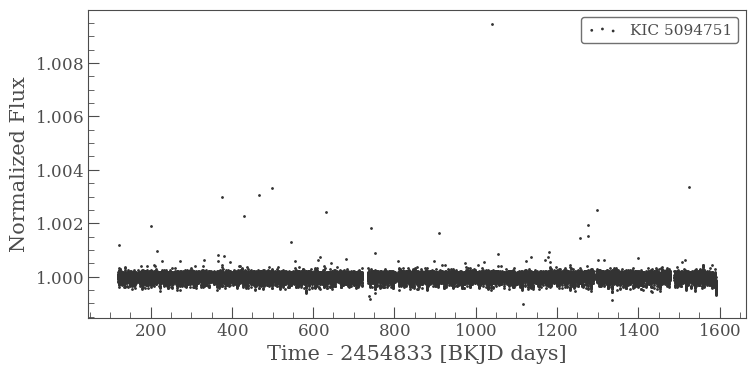

In [3]:
search_results = lk.search_lightcurve("Kepler-109", mission="Kepler", exptime=1800)
lcc = search_results.download_all()
lc = lcc.stitch().flatten().remove_nans()
lc.scatter()

(200.0, 600.0)

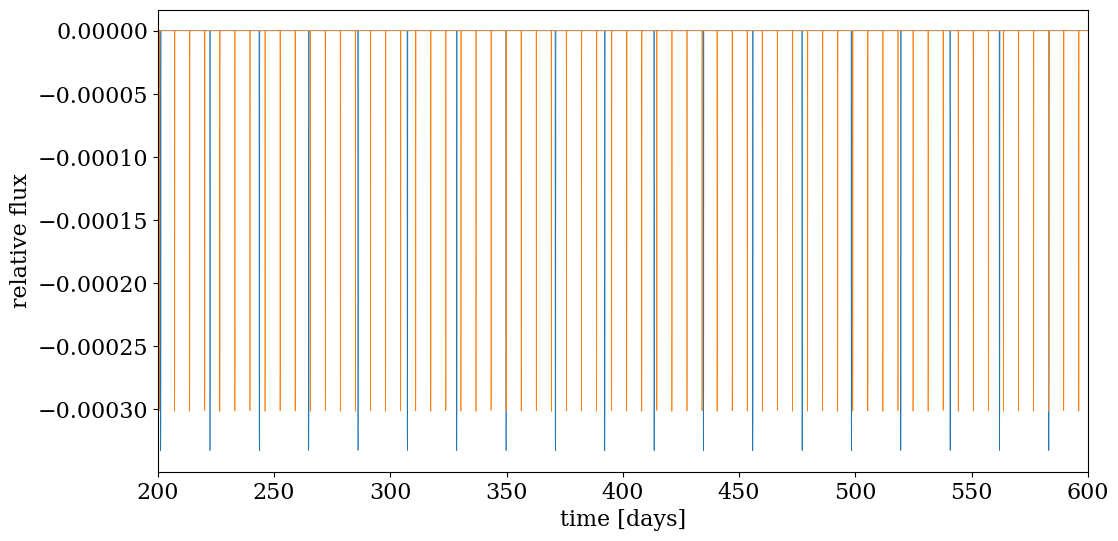

In [4]:
constant = 1

orbits = {}
for i in range(len(param_lists['pl_letter'])):
    orbits[param_lists['pl_letter'][i]] = xo.orbits.SimpleTransitOrbit(period=param_lists["pl_orbper"][i], t0=(param_lists['pl_tranmid_bkjd'][i]),
                                                                   b=param_lists['pl_imppar'][i], duration=param_lists['pl_trandur'][i]/24,
                                                                   r_star=param_lists['st_rad'][i],ror=param_lists['pl_ratror'][i])
min_t = np.floor(min(lc.time).value)
max_t = np.ceil(max(lc.time).value)
t = np.linspace(min_t, max_t, len(lc.time))
u = [0.2, 0.2]

light_curves = {}
for i in range(len(param_lists['pl_letter'])):
    light_curves[param_lists['pl_letter'][i]] = (xo.LimbDarkLightCurve(*u).get_light_curve(orbit=orbits[param_lists['pl_letter'][i]], r=param_lists['st_rad'][i]*param_lists['pl_ratror'][i],t=t)
    .eval())

plt.figure(figsize=(12,6))
plt.plot(t, light_curves['c'], color="C0", lw=0.5)
plt.plot(t, light_curves['b'], color="C1", lw=0.5)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(200,600)

In [5]:
dataset = np.array(lc.flux)

model = light_curves['c']+light_curves['b']

In [6]:
model = model.flatten()

In [7]:
difference = (dataset - model)

(0.999, 1.001)

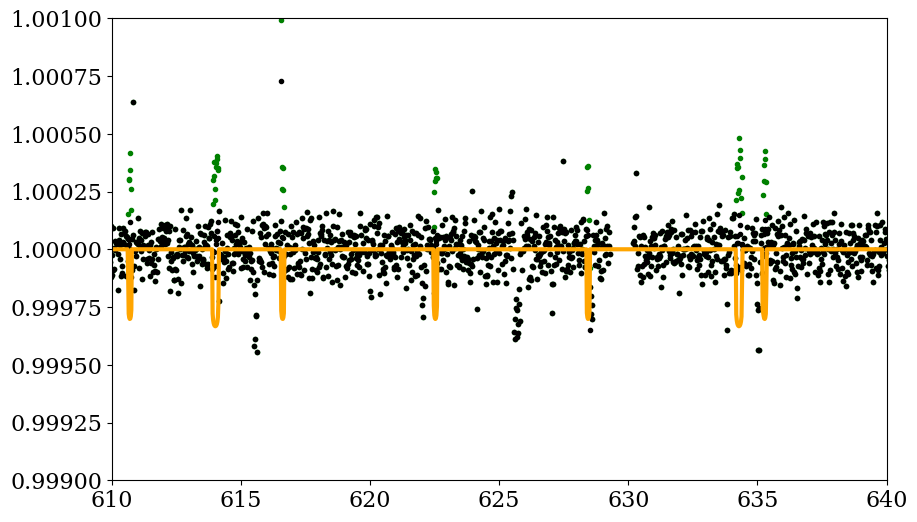

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(lc.time.value,difference,color='green',label='difference',marker='.')
plt.scatter(lc.time.value,lc.flux.value,color='k',label='data',marker='.')
plt.plot(lc.time.value, model+1,color='orange',lw=3,label='model')
plt.xlim(610,640)
plt.ylim(0.999, 1.001)

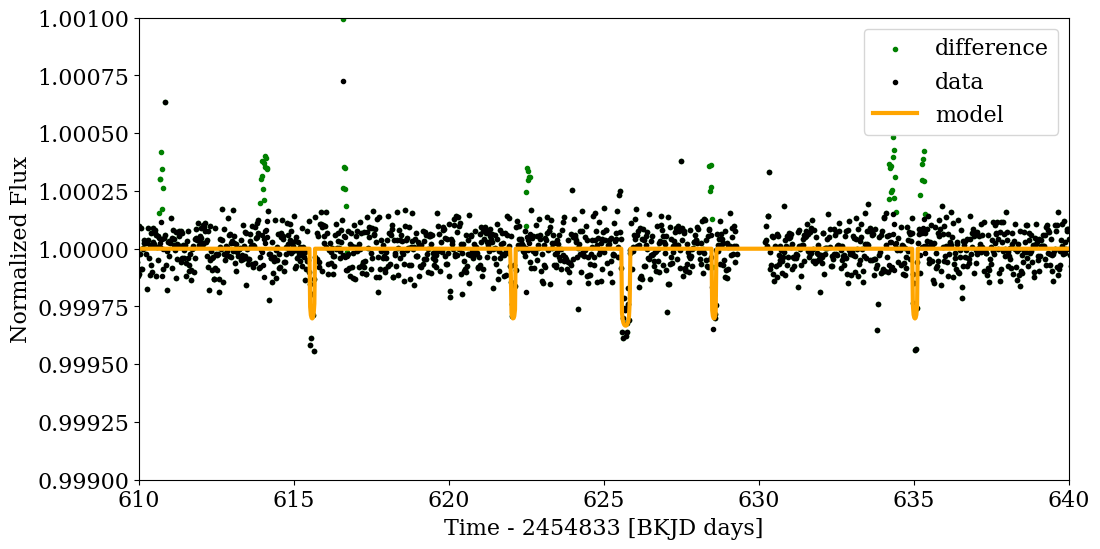

In [9]:
p = lc.scatter()
plt.close()

fig, ax = plt.subplots(figsize=(12,6))
plt.scatter(lc.time.value,difference,color='green',label='difference',marker='.')
plt.scatter(lc.time.value,lc.flux.value,color='k',label='data',marker='.')
plt.plot(t, model+1,color='orange',lw=3,label='model')
plt.xlabel(p.get_xlabel())
plt.ylabel(p.get_ylabel())
plt.xlim(610,640)
plt.ylim(0.999, 1.001)
plt.legend()

(0.9994, 1.0006)

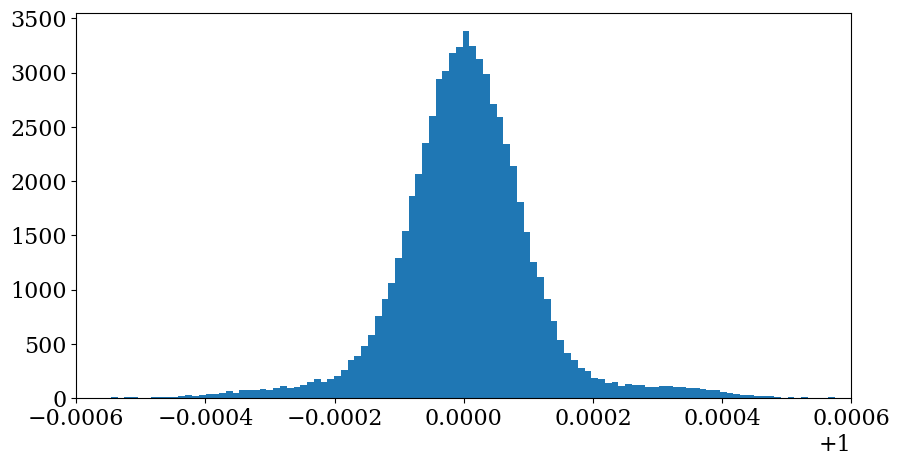

In [10]:
plt.figure(figsize=(10,5))
plt.hist(difference, bins=1000)
plt.xlim(0.9994, 1.0006)

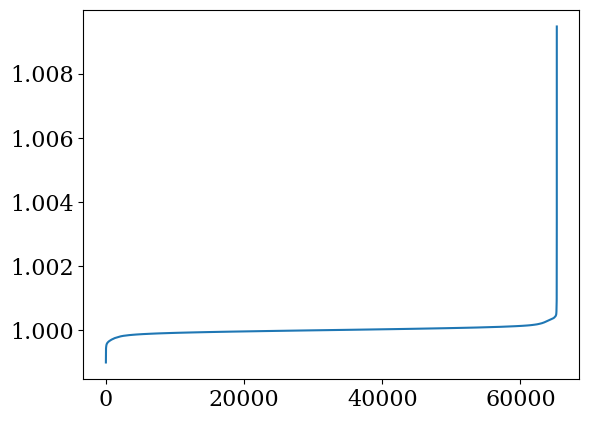

In [11]:
diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)

In [12]:
# find the two points to get std 

f = lambda x: np.interp(x, p, diff_sorted)

one_sigma_pos = f((0.8413)*N)
one_sigma_neg = f((1-0.8413)*N)
print(one_sigma_neg, one_sigma_pos)

std_calculated = (one_sigma_pos - one_sigma_neg)/2
print(std_calculated)


0.9999179868701132 1.0000896451674313
8.582914865901126e-05


(0.999, 1.001)

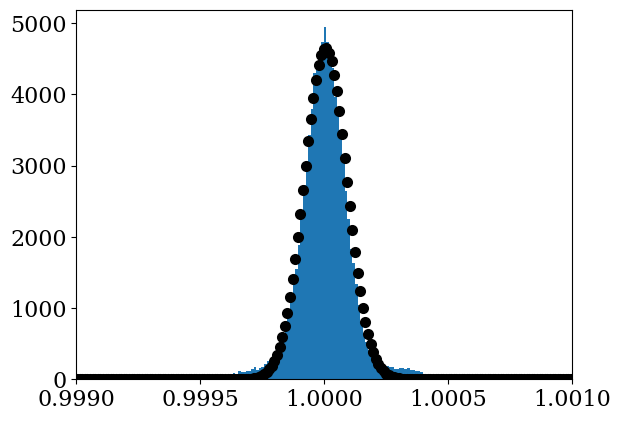

In [13]:
mu, std = norm.fit(difference)  
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.scatter(bins, norm(mu, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mu-(2*std_calculated),color='k')
#plt.axvline(mu+(2*std_calculated),color='k')
plt.xlim(0.999,1.001)

In [14]:
# note how we use the median as the center point to cut around 
mean_tweaked = np.mean(difference[((np.median(difference) - std_calculated) < difference) & (difference < (np.median(difference) + std_calculated))])
print(mean_tweaked)

1.000003131198615


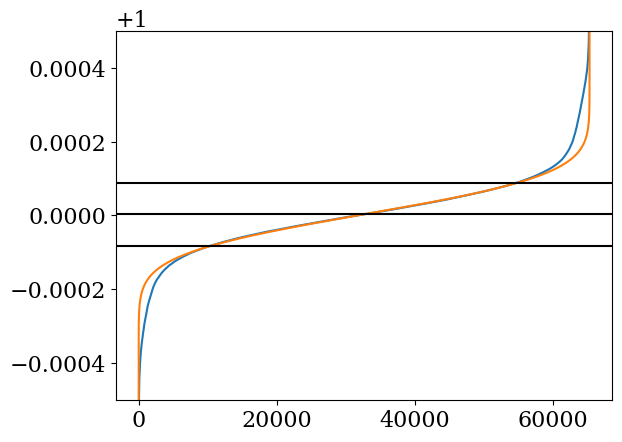

In [15]:
norm_cdf = norm.cdf((diff_sorted - mean_tweaked)/std_calculated)

diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)
plt.plot(norm_cdf*N, diff_sorted)
plt.ylim(0.9995,1.0005)
plt.axhline(mean_tweaked,color='k')
plt.axhline(mean_tweaked-std_calculated,color='k')
plt.axhline(mean_tweaked+std_calculated,color='k')

In [16]:
good_flux = lc.flux[(difference > (mean_tweaked-std_calculated)) & (difference < (mean_tweaked+std_calculated))]
good_time = lc.time[(difference > (mean_tweaked-std_calculated)) & (difference < (mean_tweaked+std_calculated))]

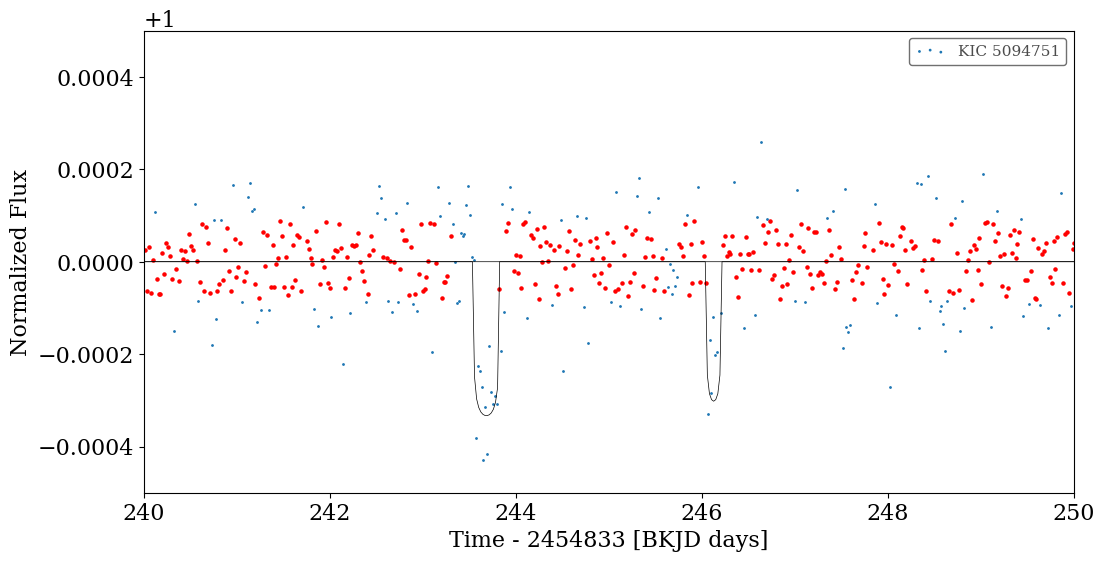

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
lc.scatter(ax=ax,norm=True,zorder=0)
plt.ion()
plt.scatter(good_time.value,good_flux,s=5,color='red',zorder=1)
plt.ylim(0.9995, 1.0005)
plt.xlim(240,250)
plt.plot(t, light_curves['c']+1, color="k", lw=0.5)
plt.plot(t, light_curves['b']+1, color="k", lw=0.5)

In [18]:
# find separation of curves 

(0.999, 1.001)

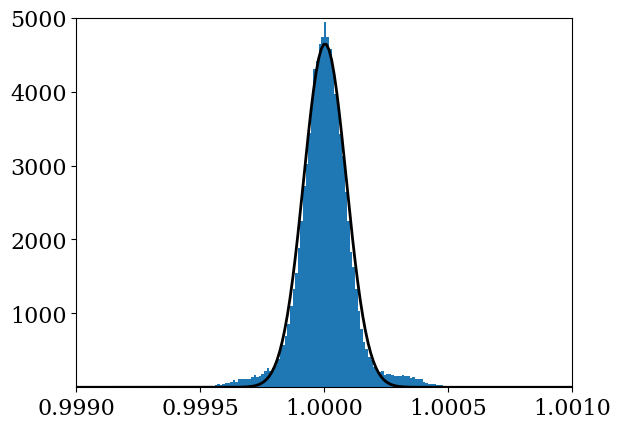

In [19]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
#plt.axvline(mean_tweaked-(2*std_calculated),color='k')
#plt.axvline(mean_tweaked+(2*std_calculated),color='k')
plt.ylim(1e-6,5000)
plt.xlim(0.999,1.001)
#plt.yscale('log')

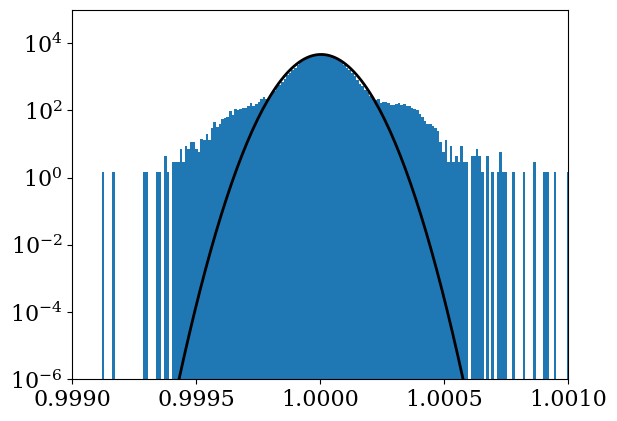

In [20]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
#plt.axvline(mean_tweaked-(2*std_calculated),color='k')
#plt.axvline(mean_tweaked+(2*std_calculated),color='k')
plt.ylim(1e-6,1e5)
plt.xlim(0.999,1.001)
plt.yscale('log')